In [163]:
import numpy as np
import matplotlib.pyplot as plt
import interneuron_amb
import stellate
from scipy import signal,optimize,stats
import phase_prec_hf as hf_p
import seaborn as sns
import sim_utils as s_utils
from neuron import h

h.load_file("stdrun.hoc")
h.celsius = 37
h.cvode.active(1)
import importlib
import analysis_utils as a_utils
importlib.reload(interneuron_amb)
importlib.reload(stellate)

<module 'stellate' from '/home/govind/gov_semproject/GridCellsTheta/GridCellsCond/stellate.py'>

In [292]:

stellate_0 = stellate.Stellate(0)
global_intrnrn = interneuron_amb.Interneuron(1)

gs_weight = 3.0
gs_inh_gmax = 5e-3  # uS
sg_weight = 0.5
sg_exc_gmax = 9.9e-4  # uS

nc_gs = h.NetCon(global_intrnrn.soma(0.5)._ref_v, stellate_0.inhb_syn, sec=global_intrnrn.soma)
nc_gs.weight[0] = gs_weight * gs_inh_gmax 

nc_sg = h.NetCon(stellate_0.soma(0.5)._ref_v, global_intrnrn.exc_syn, sec=stellate_0.soma)
nc_sg.weight[0] = sg_weight * sg_exc_gmax

theta_ic = h.IClamp(global_intrnrn.soma(0.5))
theta_ic.dur = 1e9
freq = 10
time_ms = 10000
osc_amp = 5e-5
baseline_amp = 1e-4
T, num_steps = time_ms/1000,time_ms
baseline_stell = 1e-4

stell_ic = h.IClamp(stellate_0.soma(0.5))
stell_ic.dur = 1e9  
stell_ic.amp = 1e-5

time_arr = np.linspace(0,T,num_steps)
init_phase = np.pi/2
stell_arr = np.full_like(time_arr, baseline_stell)

stell_arr[2500:] = 5e-3
stell_vec = h.Vector(stell_arr)
stell_vec.play(stell_ic._ref_amp, True)

curr_arr = osc_amp * np.sin(2 * np.pi * freq * time_arr) + np.full_like(time_arr, baseline_amp)
print((time_arr))
curr_vec = h.Vector(curr_arr)
curr_vec.play(theta_ic._ref_amp, True)

spike_times = h.Vector()

nc = h.NetCon(stellate_0.soma(0.5)._ref_v, None, sec=stellate_0.soma)
nc.threshold = 0
nc.record(spike_times)




[0.00000000e+00 1.00010001e-03 2.00020002e-03 ... 9.99799980e+00
 9.99899990e+00 1.00000000e+01]


0.0

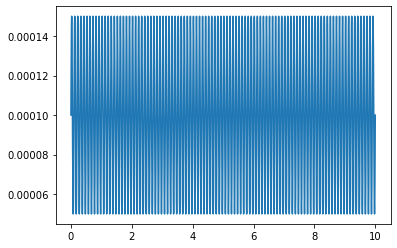

In [275]:
plt.plot(time_arr, curr_arr)

139031


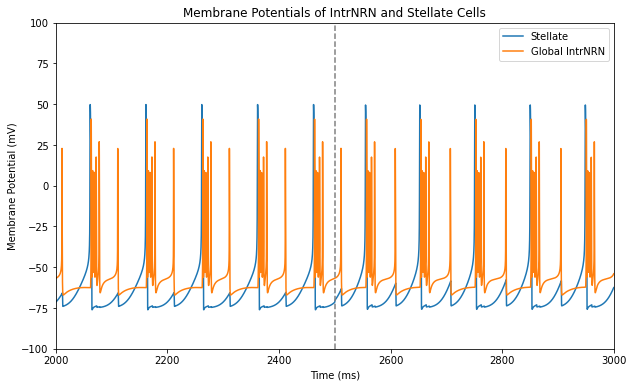

In [293]:
i_theta = h.Vector().record(theta_ic._ref_amp)

stellate_v = h.Vector().record(stellate_0.soma(0.5)._ref_v)
global_intrnrn_v = h.Vector().record(global_intrnrn.soma(0.5)._ref_v)
time = h.Vector().record(h._ref_t)


h.finitialize(-65)
h.continuerun(10000)
print(len(time.to_python()))
fig,ax = plt.subplots(figsize=(10,6))
#ax1 = ax.twinx()

ax.plot(time, stellate_v, label='Stellate')
ax.plot(time, global_intrnrn_v, label='Global IntrNRN')
##ax1.eventplot(spike_times, lineoffsets=-80, colors='r', linelengths=5, label='Stellate Spikes')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Membrane Potential (mV)')
ax.set_title('Membrane Potentials of IntrNRN and Stellate Cells')
plt.legend()
plt.ylim(-100,100)
plt.xlim(2000,3000)
plt.axvline(x=2500, color='gray', linestyle='--')
plt.show()



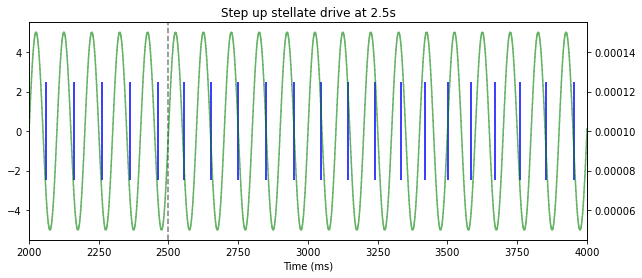

In [294]:
fig, ax = plt.subplots(figsize=(10, 4))
ax1 = ax.twinx()

ax1.plot(time, i_theta.to_python(), color='g', alpha=0.6)
ax.eventplot(spike_times, lineoffsets=0, colors='blue', linelengths=5)
ax.set_xlabel('Time (ms)')
ax.set_title('Step up stellate drive at 2.5s')
ax.set_xlim(2000,4000)
ax.axvline(x=2500, color='gray', linestyle='--')
#ax.axvline(x=3500, color='gray', linestyle='--')
plt.savefig("save_figs/theta_spk_times_step_0.png")
plt.show()

    

[0.26872946 5.88010641 5.22289242 4.67884333 4.3007225  4.08407045
 3.98051115 3.92792214 3.89253409 3.87954402 3.86995846 3.89557489
 3.89201126 3.86359798 3.8855548  3.86191832 3.86879178 3.8881092
 3.89013955 3.86600049 3.86608513 3.85676351 3.85095888 3.8575554
 3.85581092 3.87467222 3.44516244 3.26725636 3.17927617 3.14099774
 3.0601605  2.95309709 2.81966427 2.55566927 2.04219221 1.23146611
 0.16972713 5.33439251 4.34845595 3.7036415  3.41094385 3.27696861
 3.15514337 3.01592895 2.931754   2.70976457 2.38761042 1.78417585
 0.86241762 6.03256305 4.94310634 4.05890825 3.56896163 3.34119517
 3.20880721 3.15725631 3.09270341 2.98374915 2.83889619 2.6335961
 2.22400205 1.5302379  0.529338   5.69243694 4.63906696 3.86340748
 3.48590987 3.32792055 3.18096891 3.0674868  2.92800079 2.81188091
 2.58207143 2.15870569 1.44554563 0.43173558 5.59125893 4.55385089
 3.80944731 3.45575192 3.32320075 3.21045468 3.13142454 3.02197551
 2.91701632 2.77065912 2.53631162 2.07154183 1.28106141 0.2348594

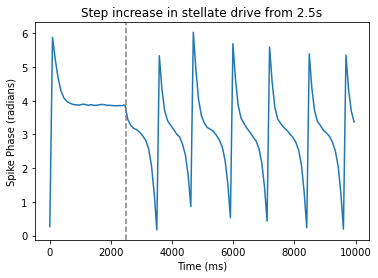

In [295]:
spike_phases = freq * 2* np.pi * (np.array(spike_times.to_python())/1000)%(2*np.pi)
print(spike_phases)
plt.plot(spike_times.to_python(),spike_phases)
plt.axvline(x=2500, color='gray', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('Spike Phase (radians)')
plt.title("Step increase in stellate drive from 2.5s")
#plt.axvline(x=3500, color='gray', linestyle='--')
plt.savefig('save_figs/phase_prec_step_sig_0.png',dpi=300)
plt.show()



In [215]:
print(len(spike_times.to_python()))

11


[2.51823633 2.68161184 2.77580959 2.82329123 2.85740896 2.93602712
 3.02632597 3.123043   3.25052678 3.4159589  3.4651622 ]


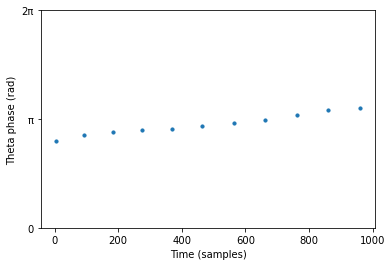

In [216]:
def vectorized_convert_angle(angles):
    return np.mod(angles, 2 * np.pi)

def calc_phase_single_stell(spike_idx, theta_signal):


    spike_idx = np.asarray(spike_idx)
    spike_idx = spike_idx[(spike_idx >= 0) & (spike_idx < len(theta_signal))]
    spike_idx = np.round(spike_idx).astype(int)

    analytic_signal = signal.hilbert(-np.array(theta_signal))
    instantaneous_phase = np.angle(analytic_signal)
    """
    Parameters
    ----------
    spike_idx : array-like
        Spike indices (NOT times)
    theta_signal : array-like
        Band-limited theta signal

    Returns
    -------
    spike_idx : np.ndarray
        Spike indices
    spike_phases : np.ndarray
        Theta phase at spike times in [0, 2π)
    """
    spike_phases = vectorized_convert_angle(
        instantaneous_phase[spike_idx]
    )

    return spike_idx, spike_phases

spike_idx, spike_phases = calc_phase_single_stell(
    spike_idx=spike_times,      # indices
    theta_signal=i_theta         # theta current
)
print(spike_phases)
first_phase = spike_phases[0]

plt.figure()
plt.scatter(spike_idx, spike_phases, s=10)
plt.xlabel("Time (samples)")
plt.ylabel("Theta phase (rad)")
plt.yticks([0, np.pi, 2*np.pi], ['0', 'π', '2π'])
plt.show()



[1.57079633 1.78977602 1.96037251 2.05470335 2.22284035 2.41945401
 2.63841251 2.86707392 3.10565839 3.31041335 3.59539187 3.84014694]


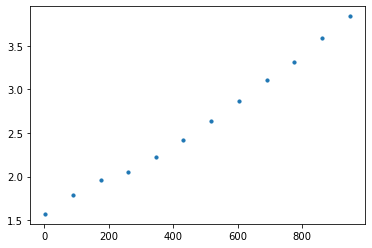

In [90]:
spike_arr = np.array(spike_times.to_python())
spike_idx = np.array(spike_arr).astype(int)

analytic_signal = signal.hilbert(-i_theta)
instantaneous_phase = np.angle(analytic_signal)
stell_phase = vectorized_convert_angle(instantaneous_phase)
print(stell_phase[spike_idx])
plt.scatter(spike_idx, stell_phase[spike_idx], s=10)




In [140]:
theta = i_theta.to_python()

print(type(theta))
print(np.asarray(theta).shape)
print(theta)

<class 'list'>
(15224,)
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.7701032291200795e-06, 3.7701032291200795e-06, 3.7701032291200795e-06, 3.7701032291200795e-06, 3.7701032291200795e-06, 3.7701032291200795e-06, 3.7701032291200795e-06, 3.7701032291200795e-06, 3.7701032291200795e-06, 3.7701032291200795e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 7.518741090696835e-06, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878629e-05, 1.1224570431878

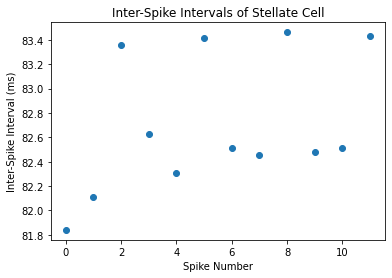

In [152]:
isi_array = np.diff(spike_times.to_python())    
plt.scatter(range(len(isi_array)), isi_array)
plt.xlabel('Spike Number') 
plt.ylabel('Inter-Spike Interval (ms)')
plt.title('Inter-Spike Intervals of Stellate Cell')
plt.show()                         

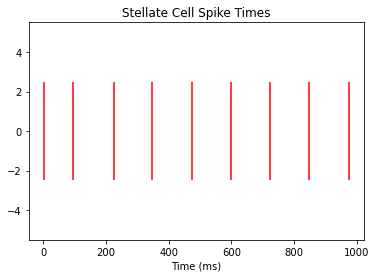

In [7]:
plt.eventplot(spike_times, lineoffsets=0, colors='r', linelengths=5)
plt.xlabel('Time (ms)')
plt.title('Stellate Cell Spike Times')
plt.show()

In [ ]:
stell_spikes_l = spike_times